### This is a test Jupyter notebook with all the functions to train a feed forward neural network model on Enformer predictions of cfDNA fragments. For details on each function, refer to train_model_refactored.py file.

In [6]:
import sys
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')
import importlib
import torch
torch.cuda.empty_cache()

import numpy as np
import pandas as pd
import os
from datetime import datetime
import time

from torch.utils.data import DataLoader

import torch.optim as optim
from torch import nn
from torch.nn.functional import one_hot

import config
import plotUtils
import enformerOutputDataset
import enformerOutputDenseLayerModel as basicDenseLayer
import simpleDenseLayer

importlib.reload(basicDenseLayer)
importlib.reload(simpleDenseLayer)
importlib.reload(enformerOutputDataset)
importlib.reload(plotUtils)
importlib.reload(config)

Arguments in plotUtils are {'trainingAndValidationOutputsDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/test_simulations', 'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/OnlyTwoCoordinateFilesForTestingSmall', 'trainingEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/training_test.hdf5', 'validationEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/validation_test.hdf5', 'trainingDataFile': 'trainingData.pkl', 'validationDataFile': 'validationData.pkl', 'trainingLossLearningRateFile': 'trainingLossLearningRateData.pkl', 'validationLossLearningRateFile': 'validationLossLearningRateData.pkl', 'checkpointsFile': 'modelCheckPoints', 'threshold': 0.5, 'batchSize': 128, 'learningRate': 0.0001, 'numEpochs': 5, 'useCosineLearningFunction': False, 'storePlots': True, 'trainingLabelsDatasetName': 'tr

<module 'config' from '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/config.py'>

In [7]:
arguments = {}
#Model hyperparameters
arguments["batchSize"] = config.modelHyperParameters.get("batchSize")
arguments["learningRate"] = config.testConfigs.get("learningRate")
arguments["numberOfWorkers"] = config.modelHyperParameters.get("numberOfWorkers")
arguments["numberEpochs"] = config.testConfigs.get("numberEpochs")
arguments["useCosineLearningFunction"] = config.testConfigs.get("useCosineLearningFunction")

#Model general configs
arguments["trainingStartIndex"] = config.modelGeneralConfigs.get("startIndexEnformerSamplesTraining")
arguments["validationStartIndex"] = config.modelGeneralConfigs.get("startIndexEnformerSamplesValidation")
arguments["normalizeFeatures"] = config.modelGeneralConfigs.get("normalizeFeatures")
arguments["runWithControls"] = config.testConfigs.get("runWithControls")

#Configs and file paths required for restoring from checkpoint
arguments["restoreFromCheckpoint"] = config.testConfigs.get("restoreFromCheckpoint")
arguments["storePlots"] = config.testConfigs.get("storePlots")
arguments["modelName"] = config.modelGeneralConfigs.get("modelName")
arguments["trainingAndValidationOutputsDirectory"] = config.testFilePaths.get("trainingAndValidationOutputsDirectory")
arguments["checkpointsFile"] = config.filePaths.get("checkpointsFile")
arguments["restoreCheckpointModelDirName"] = config.filePaths.get("restoreCheckpointModelDirName")

#Files to run the model for simulated data
arguments["trainingEnformerTracksAverageFile"] = config.filePaths.get("trainingEnformerTracksAverageFile")
arguments["validationEnformerTracksAverageFile"] = config.filePaths.get("validationEnformerTracksAverageFile")

print(arguments)

{'batchSize': 128, 'learningRate': 0.0001, 'numberOfWorkers': 12, 'numberEpochs': 5, 'useCosineLearningFunction': False, 'trainingStartIndex': 0, 'validationStartIndex': 0, 'normalizeFeatures': False, 'runWithControls': True, 'restoreFromCheckpoint': False, 'storePlots': True, 'modelName': 'two_hidden_layer_cosine_lr_0.000001', 'trainingAndValidationOutputsDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/test_simulations', 'checkpointsFile': 'modelCheckPoints', 'restoreCheckpointModelDirName': '06_11_13_45_05_two_hidden_layer_lr_0.00001', 'trainingEnformerTracksAverageFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/training_enformer_track_averages.csv', 'validationEnformerTracksAverageFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/validation_enformer_track_averages.csv'}


In [3]:
def trainModelGetPredictionsForEpoch(denseLayerModel, dataloader, criterion,
                              isTraining=False, optimizer = False):

    plotsData = {} #Dict with keys labels, inputData, predictions, epoch, loss, learningRates
    learning_rates = []

    #TODO come up with a better way to initialize this rather than creating 0s arrays. This will also remove the slicing from the return statement
    modelPredictionsToRet = np.zeros(shape = (1, 2))
    modelInputDataToRet = np.zeros(shape = (1, 10626))
    modelInputLabelsToRet = []
    
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        enformerPrediction, classLabels = data
        if torch.cuda.is_available():
            #While creating torch.tensor, device can be passed as cuda. But that was a suspect for GPU node running out of memory.
            #After iterating through dataset and fetching each sample, send the labels and sequence to cuda
            #The class labels should be of type integer. 
            #TODO modify sampler function 
            #Because we use the sampler, there is an extra dimension for the labels and enformer output. [1*128*10626].
            #Take only the 1st element to remove the extra dimension. 
            enformerPrediction = enformerPrediction[0].to('cuda')
            classLabels = classLabels.to(torch.int64)[0].flatten().to('cuda')

        #The class labels have to be encoded into probabilities of type floating point
        probabilityLabels = one_hot(classLabels, num_classes=2).to(torch.float32)
        modelPrediction = denseLayerModel(enformerPrediction)
        loss = criterion(modelPrediction, probabilityLabels)
    
        #If the model is being trained, then do backpropagation and calculate loss. 
        if(isTraining):
            #zero grad is applicable only for optimizers and not for cosine annealing function schedulers. 
            if arguments["useCosineLearningFunction"] != True:
                optimizer.zero_grad()

            # Backward pass and calculate the gradients
            loss.backward()
            optimizer.step()

        #Collect data for plotting graphs
        running_loss += loss.item()
        if arguments["useCosineLearningFunction"] and isTraining:
            learning_rates.append(optimizer.get_lr())

        # modelInputDataToRet =  np.row_stack([modelInputDataToRet, enformerPrediction.detach().cpu().numpy()]) #For now we are not using the data anywhere, so adding this is not necessary. 
        modelInputLabelsToRet.extend(classLabels.cpu())
        modelPredictionsToRet = np.row_stack([modelPredictionsToRet, modelPrediction.detach().cpu().numpy()])
    
    avg_loss_per_batch = running_loss/len(dataloader)
    plotsData["labels"] = modelInputLabelsToRet
    plotsData["inputData"] = modelInputDataToRet[1:, :]
    plotsData["predictions"] = modelPredictionsToRet[1:, :]
    
    return plotsData, avg_loss_per_batch, learning_rates

In [4]:
def objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path):
    denseLayerModel = basicDenseLayer.BasicDenseLayer().to('cuda')

    #Training dataloader
    if(arguments["runWithControls"] == True):
        training_enformer_track_ranges = pd.read_csv(arguments["trainingEnformerTracksAverageFile"], sep='\t')
        validation_enformer_track_ranges = pd.read_csv(arguments["validationEnformerTracksAverageFile"], sep='\t')
        
        percent_features =  arguments["percentageFeaturesAsControls"]
        percent_samples = arguments["percentageSamplesAsControls"]
        print(f"Running the model with controls, about to create datasets. percent_aug_feats: {percent_features} and percent_aug_samples: {percent_samples}")
        trainingDataset = enformerOutputDataset.EnformerOutputDataset("training", arguments["normalizeFeatures"], training_enformer_track_ranges, 
                                                                      percent_features, percent_samples)
        
        validationDataset = enformerOutputDataset.EnformerOutputDataset("validation", arguments["normalizeFeatures"], validation_enformer_track_ranges, 
                                                                        percent_features, percent_samples)

        print(f"Num of training samples: {len(trainingDataset)} and validation samples: {len(validationDataset)}")

    else:
        trainingDataset = enformerOutputDataset.EnformerOutputDataset("training", arguments["normalizeFeatures"])
        validationDataset = enformerOutputDataset.EnformerOutputDataset("validation", arguments["normalizeFeatures"])

    #Get training dataloader
    rangeTrainingSampler = range(arguments["trainingStartIndex"] , len(trainingDataset) + arguments["trainingStartIndex"])
    trainingsampler = torch.utils.data.BatchSampler(rangeTrainingSampler, batch_size=batchSize,
                                            drop_last=False )
    trainingDataloader = DataLoader(trainingDataset,  num_workers=numWorkers, sampler=trainingsampler)

    #Get validation dataloader
    rangeValidationSampler = range(arguments["validationStartIndex"] , len(validationDataset) + arguments["validationStartIndex"])
    validation_sampler = torch.utils.data.BatchSampler(rangeValidationSampler, batch_size=batchSize,
                                            drop_last=False )
    validationDataloader = DataLoader(validationDataset, num_workers=numWorkers, sampler=validation_sampler)

    #Get loss function
    training_class_weights = trainingDataset.getClassWeights()
    criterion = nn.CrossEntropyLoss(weight = torch.tensor(training_class_weights).to('cuda'))
    # criterion = nn.BCEWithLogitsLoss()

    #If restoring from a previous checkpoint, load the modek and optimizer state dict 
    epoch_to_start = 1

    if(arguments["restoreFromCheckpoint"]):
        checkpoint_path = os.path.join(plots_directory_path, arguments["checkpointsFile"])
        checkpoint_dict = torch.load(checkpoint_path)
        denseLayerModel.load_state_dict(checkpoint_dict["model_state_dict"])
        epoch_to_start = checkpoint_dict["epoch"] + 1
        print(f"Restore from checkpoint is True.. loading previous model checkpoint and starting from epoch : {epoch_to_start}")
    
    training_num_batches = len(trainingDataloader)
    optimizer = optim.Adam(denseLayerModel.parameters(), lr=learningRate)

    if(arguments["restoreFromCheckpoint"]):
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])

    if arguments["useCosineLearningFunction"]:
        optimizer_steps = (training_num_batches * numEpochs) #Number of steps in gradient descent. 
        optimizer_to_use_for_training = optim.lr_scheduler.CosineAnnealingLR(optimizer, optimizer_steps, last_epoch = epoch_to_start - 2, eta_min=0)
    else:
        optimizer_to_use_for_training = optimizer

    #Train model and validate it for each epoch
    for epoch in range(epoch_to_start, numEpochs + 1):
        print(f"Starting training for epoch {epoch}")
        trainingPlotsData, training_loss, training_learning_rates = trainModelGetPredictionsForEpoch(denseLayerModel, 
                                            trainingDataloader, criterion, isTraining=True, optimizer=optimizer_to_use_for_training)
        trainingPlotsData["epoch"] = epoch
        print(f"Finished training for epoch {epoch}. Starting validations")
        
        #Validation
        with torch.no_grad():
            validationPlotsData, validation_loss, validation_learning_rates = trainModelGetPredictionsForEpoch(denseLayerModel, 
                                                validationDataloader, criterion, isTraining=False)
            validationPlotsData["epoch"] = epoch
            
        #For every epoch, save the model checkpoint and the plotsData so far. 
        plotUtils.saveModelCheckpoint(epoch, denseLayerModel, optimizer, plots_directory_path)
        plotUtils.savePlotsData("training", trainingPlotsData, training_loss, training_learning_rates, plots_directory_path)
        plotUtils.savePlotsData("validation", validationPlotsData, validation_loss, validation_learning_rates, plots_directory_path)

    print(f"Completed training and validation. Saving model and plotting loss function graphs. ")
    plotUtils.storePlots(plots_directory_path, modelInputType="Enformer")

Start time is 1699295425.6426373
The model hyper parameters are Learning Rate: 0.0001, numWorkers: 12, numEpochs: 20, batchSize: 128
Inside new init
The model is being run with simulated data. The total num samples acc. to configs is 500000
Num of training samples: 500000
The model is being run with simulated data. The total num samples acc. to configs is 500000
Inside new init
The model is being run with simulated data. The total num samples acc. to configs is 125000
Num of validation samples: 125000
The model is being run with simulated data. The total num samples acc. to configs is 125000
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Starting training for epoch 3
Finished training for epoch 3. Starting validations
Inside save model check point
Starting training for epoch 4
Finished training for epoch 4. Star

OSError: Unable to open file (bad object header version number)

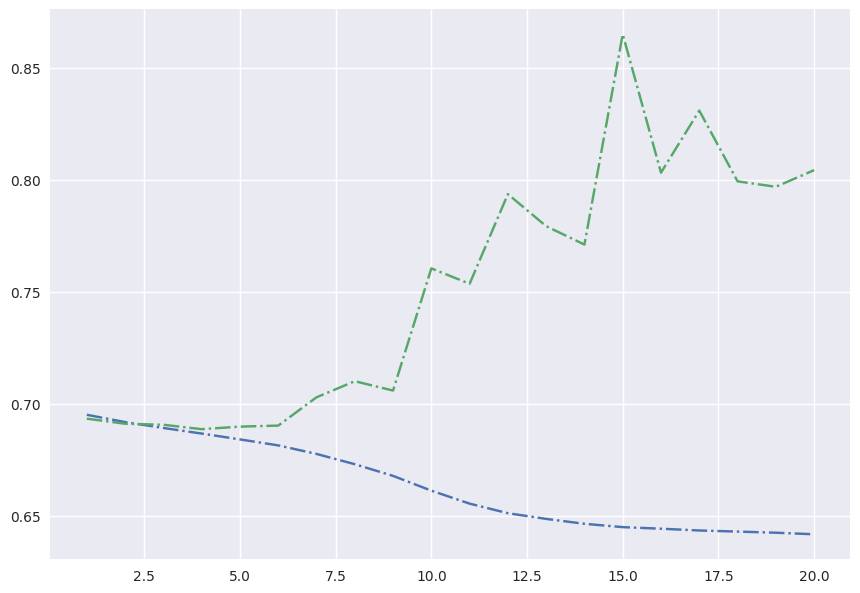

In [180]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")
    learningRate = arguments["learningRate"]
    numWorkers = arguments["numberOfWorkers"]
    numEpochs = arguments["numberEpochs"]
    batchSize = arguments["batchSize"]

    print(f"The model hyper parameters are Learning Rate: {learningRate}, numWorkers: {numWorkers}, numEpochs: {numEpochs}, batchSize: {batchSize}")
    
    #Create the directories for plots and checkpoints
    if(arguments["restoreFromCheckpoint"]):
        plots_directory_name = arguments["restoreCheckpointModelDirName"]
        plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
    else:
        now = datetime.now()
        filename_extension = now.strftime("%d_%m_%H_%M_%S")
        plots_directory_name = filename_extension + "_" + str(arguments["modelName"])
        plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
        os.mkdir(plots_directory_path)

    objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path)
    print(f"End time is {time.time()}")

In [ ]:
import enformerOutputDataset
importlib.reload(enformerOutputDataset)

training_enformer_track_ranges = None
validation_enformer_track_ranges = None

#If run with controls is true, then fetch the averages and pass to the dataset
if(arguments["runWithControls"] == True):
    print(f"Run with controls is true")
    training_enformer_track_ranges = pd.read_csv(arguments["trainingEnformerTracksAverageFile"], sep='\t')
    validation_enformer_track_ranges = pd.read_csv(arguments["validationEnformerTracksAverageFile"], sep='\t')
    
#Training dataloader
trainingDataset = enformerOutputDataset.EnformerOutputDataset("training", arguments["normalizeFeatures"], training_enformer_track_ranges)
print(f"Num of training samples: {len(trainingDataset)}")
rangeTrainingSampler = range(arguments["trainingStartIndex"] , len(trainingDataset) + arguments["trainingStartIndex"])
trainingsampler = torch.utils.data.BatchSampler(rangeTrainingSampler, batch_size=batchSize,
                                        drop_last=False )
trainingDataloader = DataLoader(trainingDataset,  num_workers=numWorkers, sampler=trainingsampler)

#Validation dataloader
validationDataset = enformerOutputDataset.EnformerOutputDataset("validation", arguments["normalizeFeatures"], validation_enformer_track_ranges)
print(f"Num of validation samples: {len(validationDataset)}")
rangeValidationSampler = range(arguments["validationStartIndex"] , len(validationDataset) + arguments["validationStartIndex"])
validation_sampler = torch.utils.data.BatchSampler(rangeValidationSampler, batch_size=batchSize,
                                        drop_last=False )
validationDataloader = DataLoader(validationDataset, num_workers=numWorkers, sampler=validation_sampler)

for i, data in enumerate(trainingDataloader):
    enformerPrediction, classLabels = data
    print(f"Inside batch {i}. Shape of enformer predictions: {enformerPrediction.shape} and classLabels : {classLabels.shape}")

Start time is 1699363229.1663728
The model hyper parameters are Learning Rate: 0.0001, numWorkers: 12, numEpochs: 5, batchSize: 128
Starting the model for Sample percent : 10 and feature percent : 10
Running the model with controls, about to create datasets. percent_aug_feats: 10 and percent_aug_samples: 10
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Num of training samples: 10000 and validation samples: 2000
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Starting training for epoch 3
Finished traini

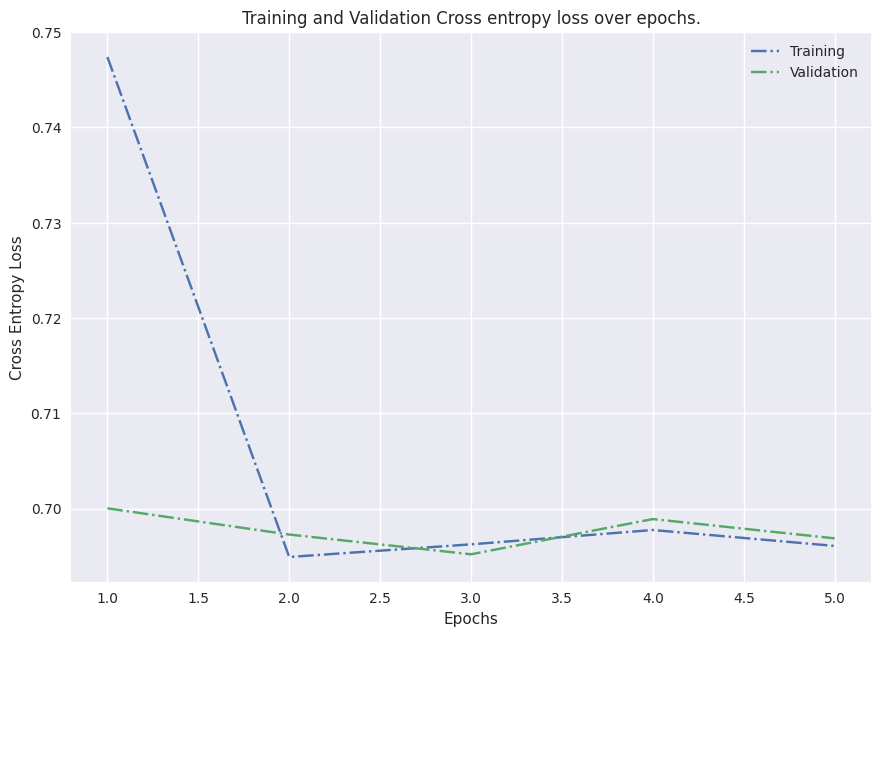

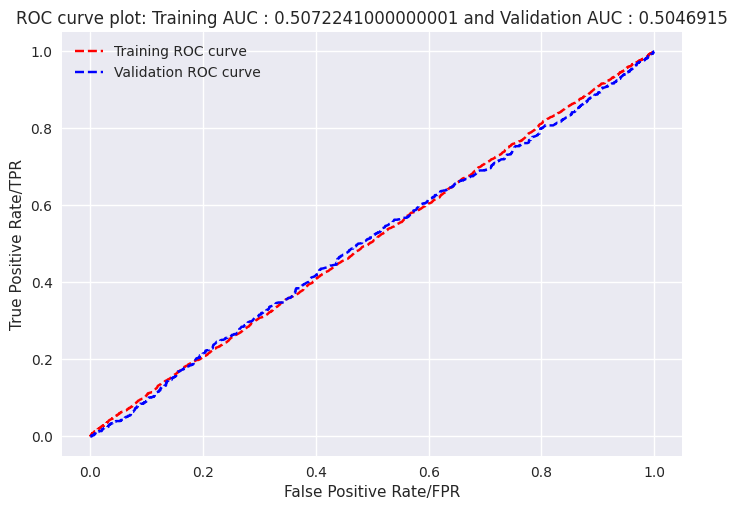

<Figure size 800x550 with 0 Axes>

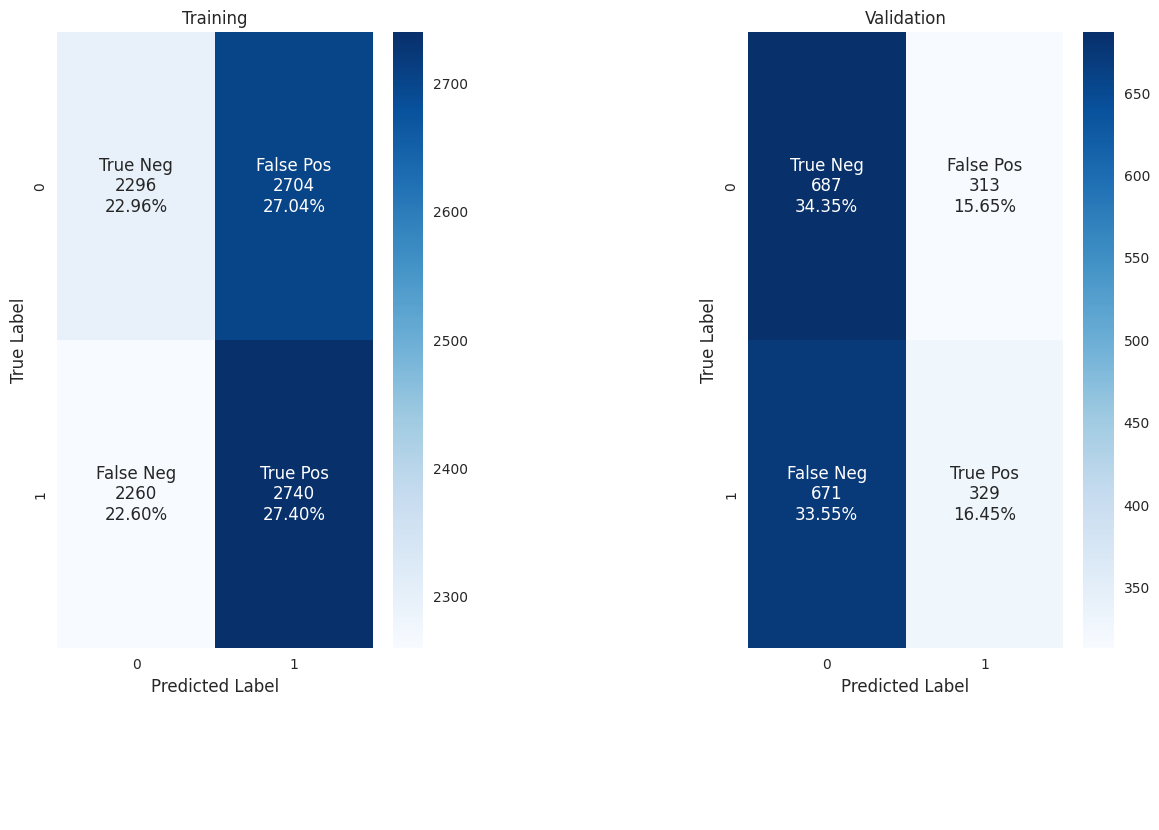

<Figure size 800x550 with 0 Axes>

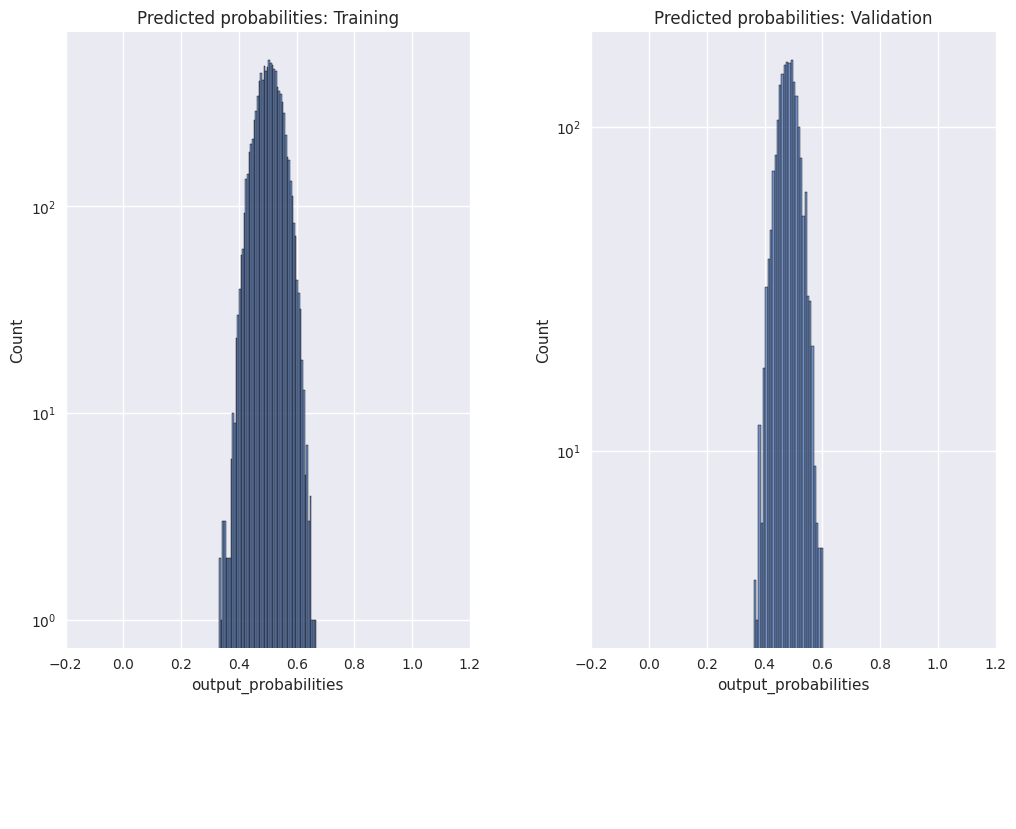

<Figure size 800x550 with 0 Axes>

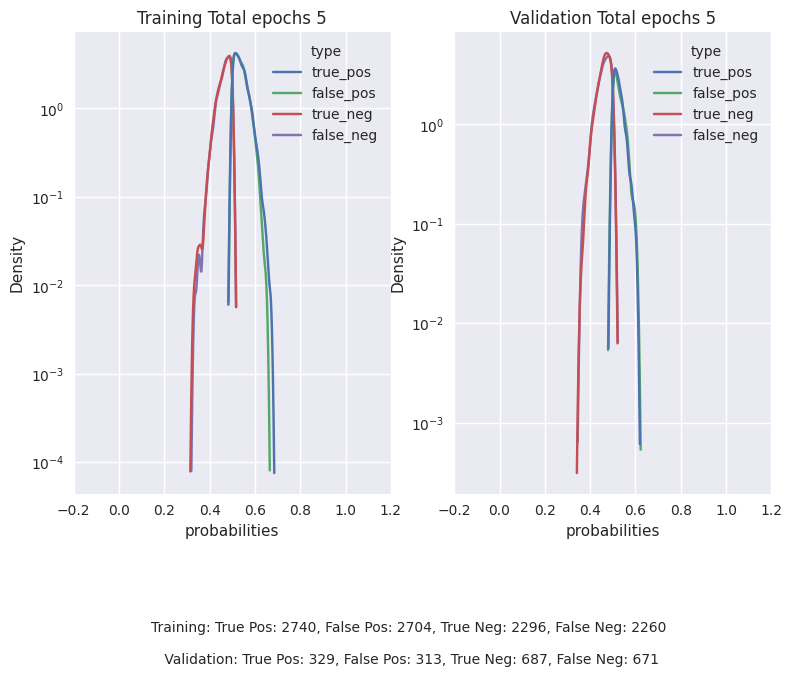

Starting the model for Sample percent : 10 and feature percent : 30
Running the model with controls, about to create datasets. percent_aug_feats: 30 and percent_aug_samples: 10
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Num of training samples: 10000 and validation samples: 2000
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Starting training for epoch 3
Finished training for epoch 3. Starting validations
Inside save model check point
Starting training for epoch 4
Finished training for epoch 4. Star

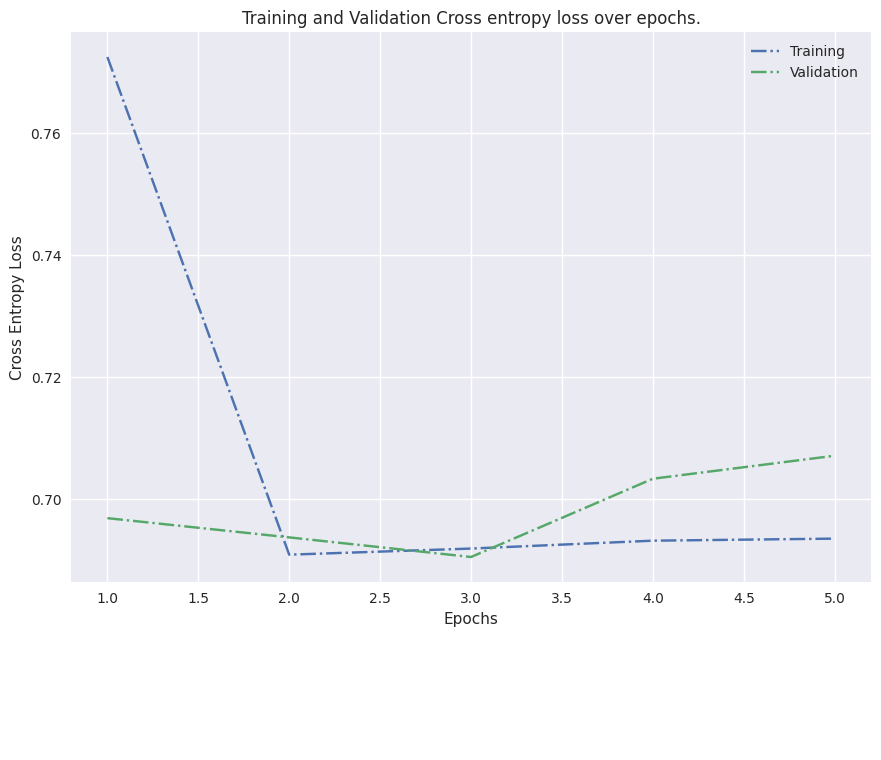

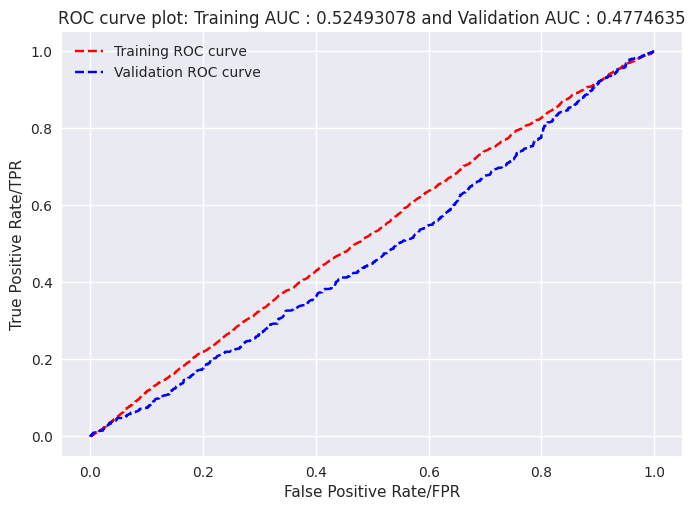

<Figure size 800x550 with 0 Axes>

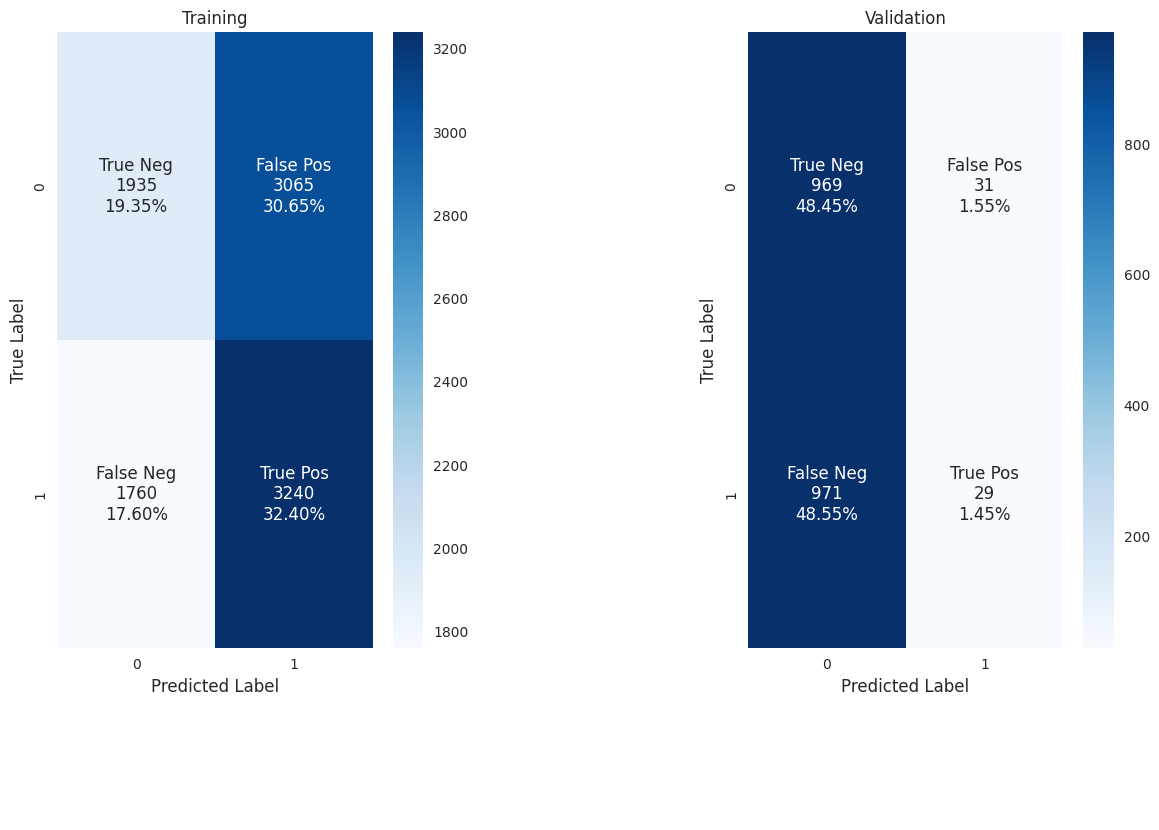

<Figure size 800x550 with 0 Axes>

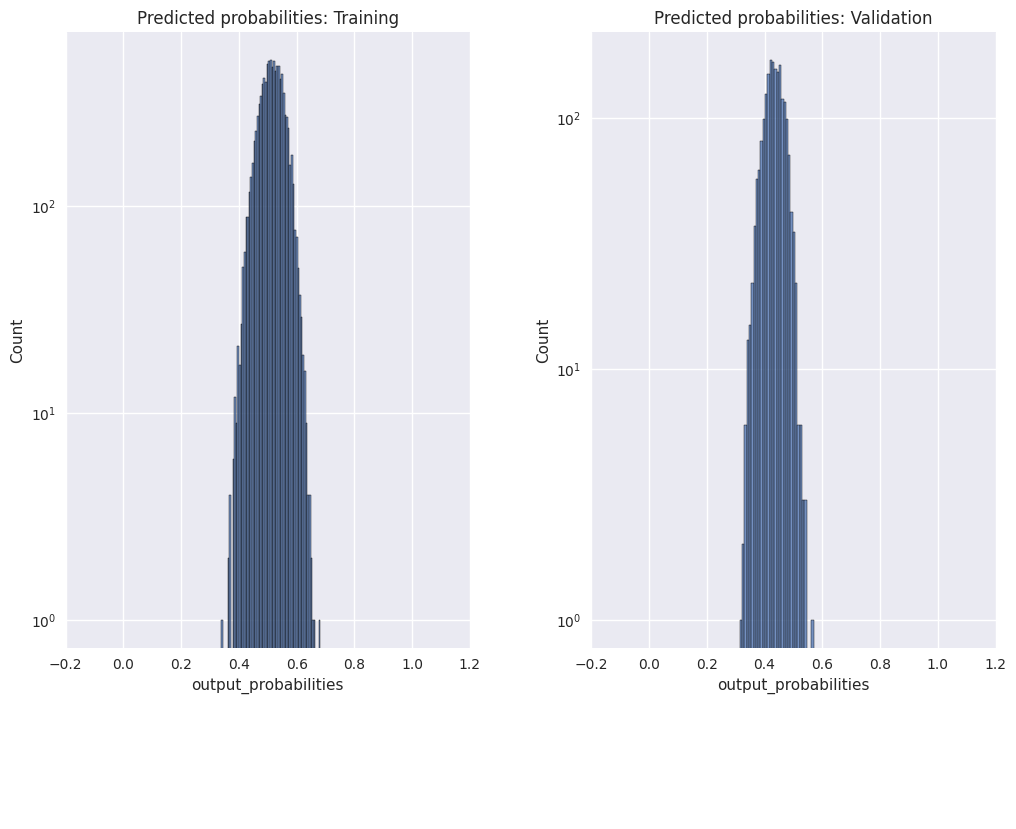

<Figure size 800x550 with 0 Axes>

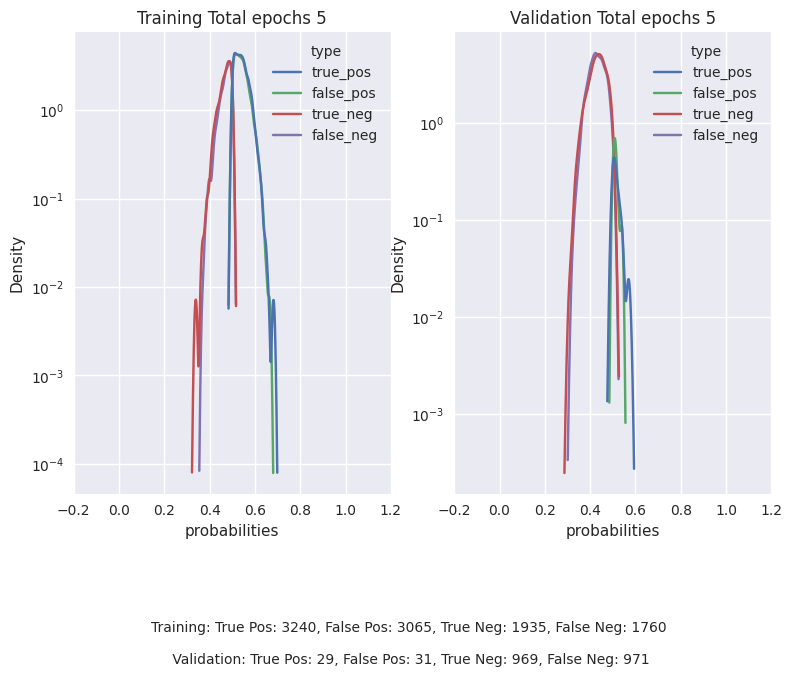

Starting the model for Sample percent : 30 and feature percent : 10
Running the model with controls, about to create datasets. percent_aug_feats: 10 and percent_aug_samples: 30
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Num of training samples: 10000 and validation samples: 2000
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Starting training for epoch 3
Finished training for epoch 3. Starting validations
Inside save model check point
Starting training for epoch 4
Finished training for epoch 4. Star

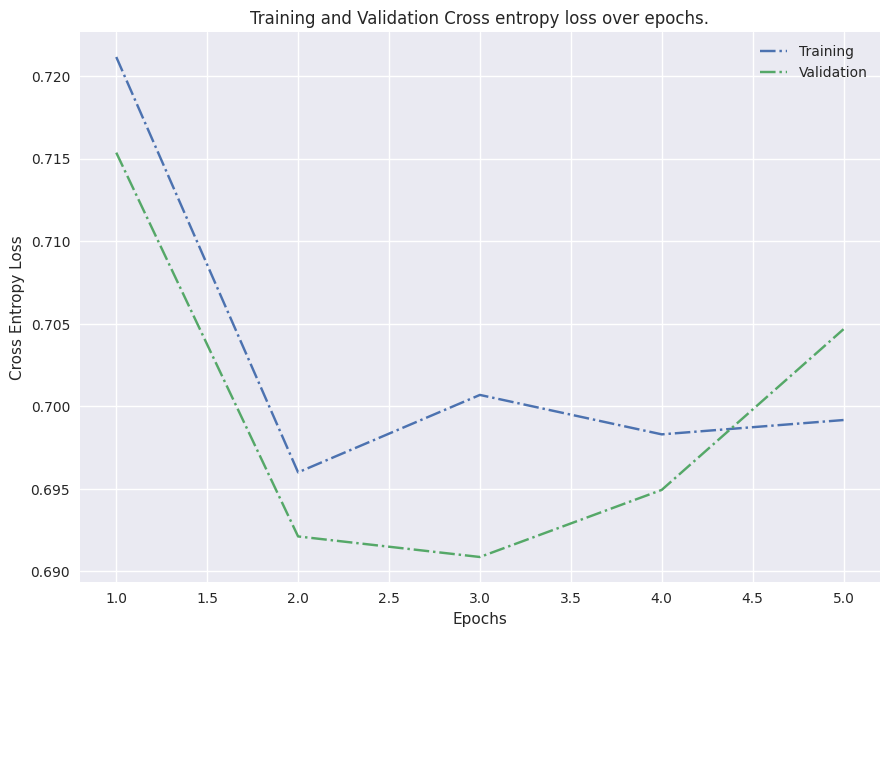

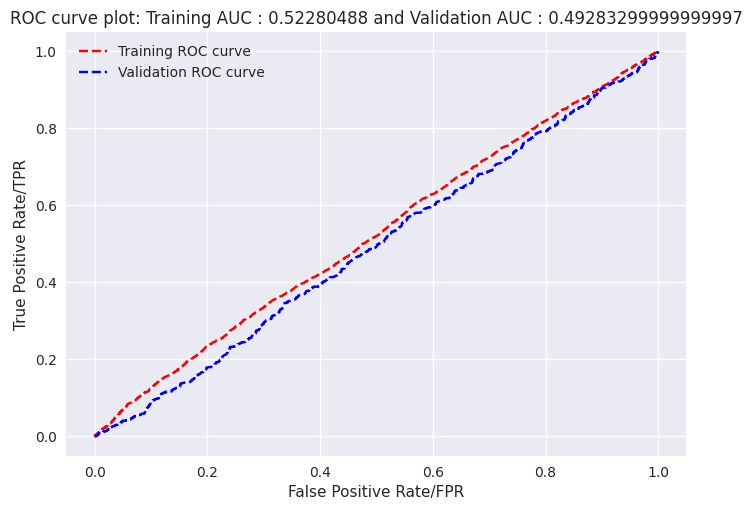

<Figure size 800x550 with 0 Axes>

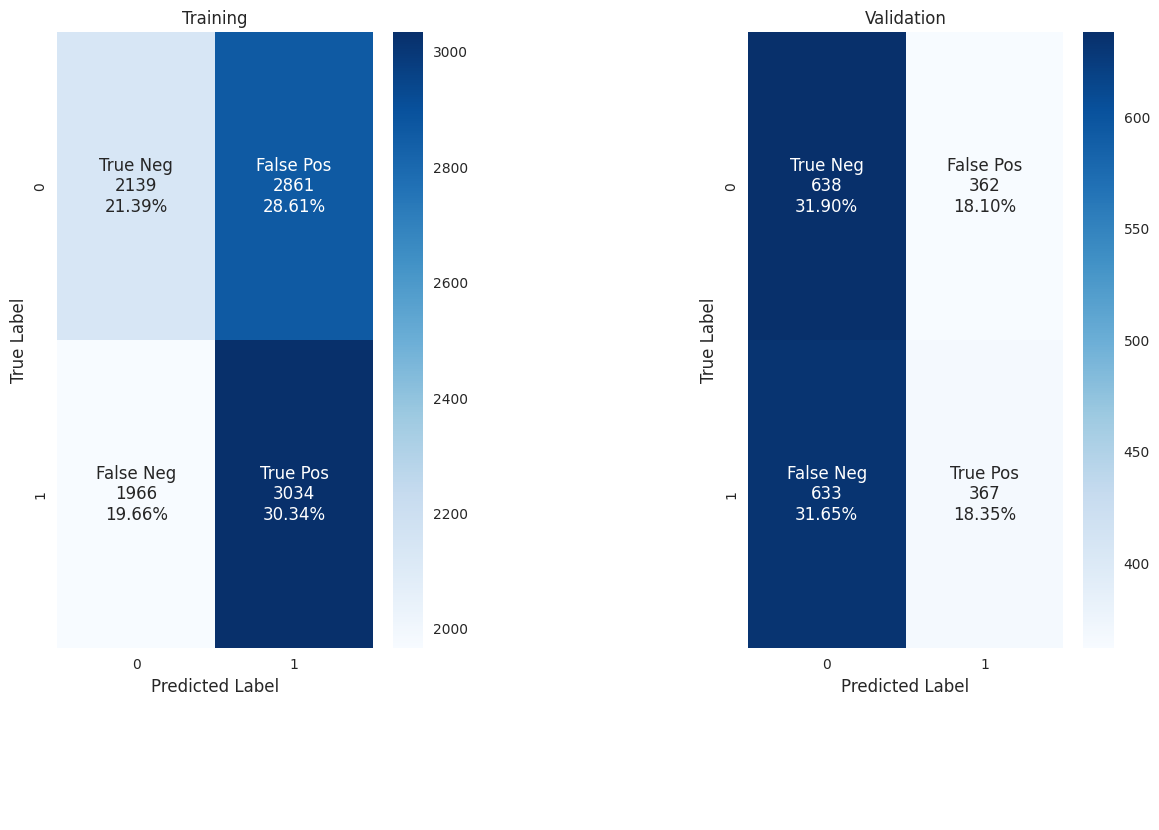

<Figure size 800x550 with 0 Axes>

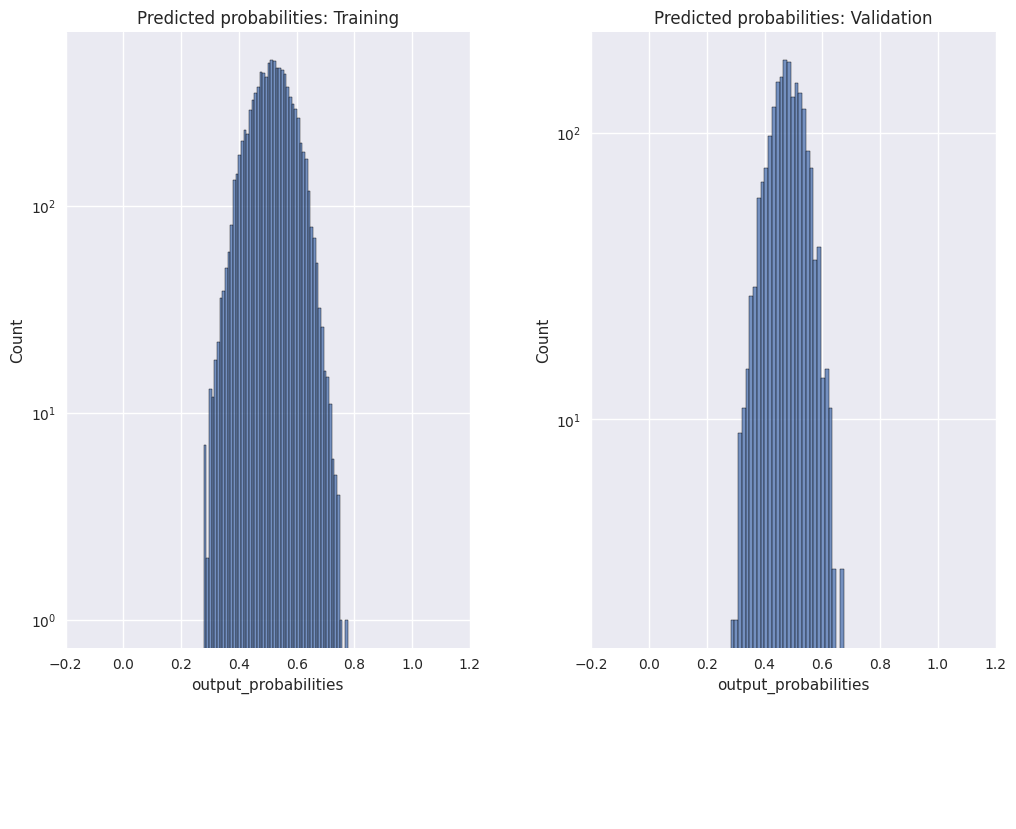

<Figure size 800x550 with 0 Axes>

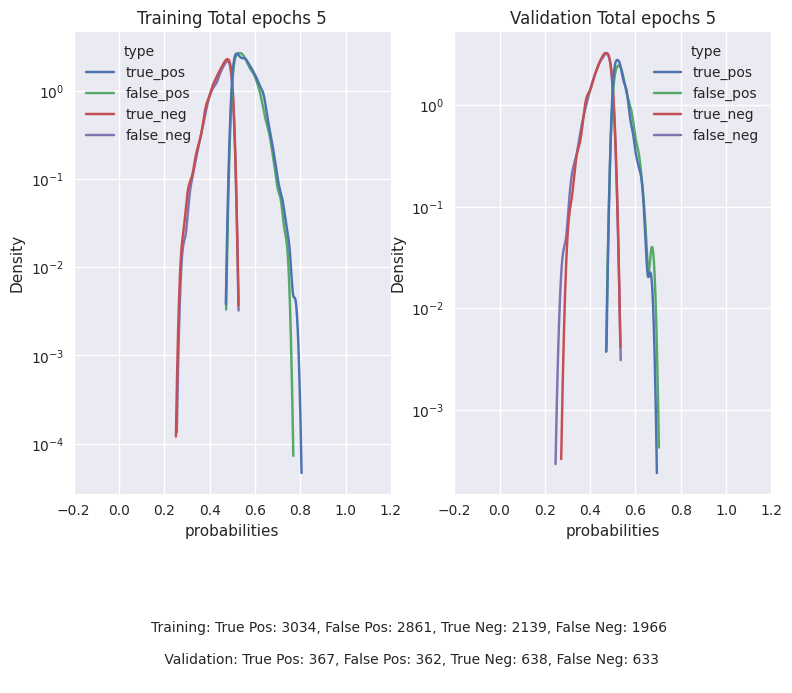

Starting the model for Sample percent : 30 and feature percent : 30
Running the model with controls, about to create datasets. percent_aug_feats: 30 and percent_aug_samples: 30
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Num of training samples: 10000 and validation samples: 2000
The model is being run with simulated data. The total num samples acc. to configs is 10000
The model is being run with simulated data. The total num samples acc. to configs is 2000
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Starting training for epoch 3
Finished training for epoch 3. Starting validations
Inside save model check point
Starting training for epoch 4
Finished training for epoch 4. Star

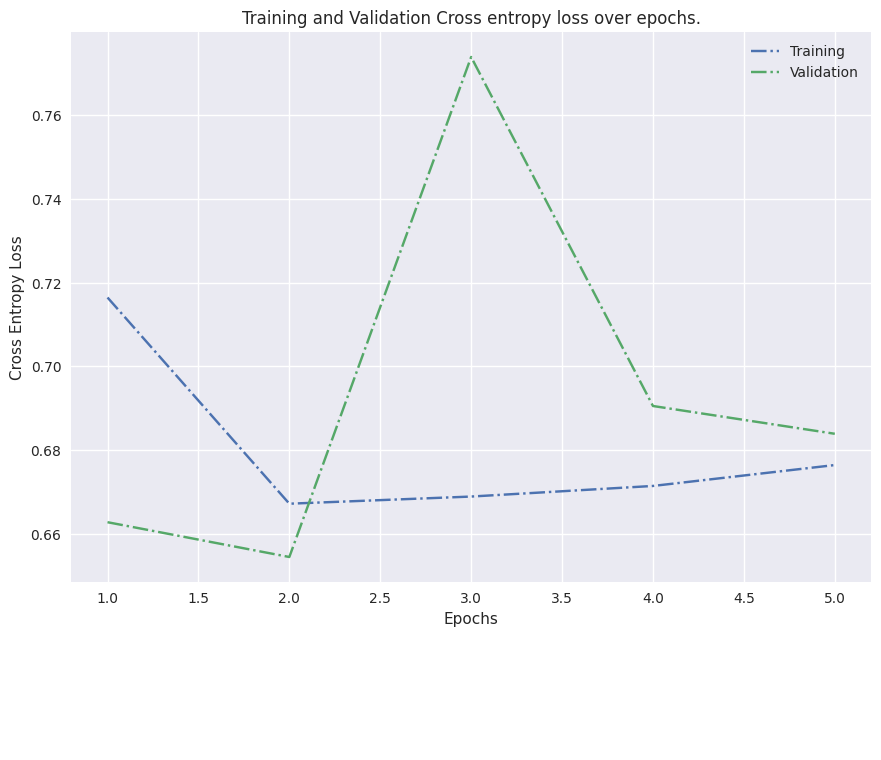

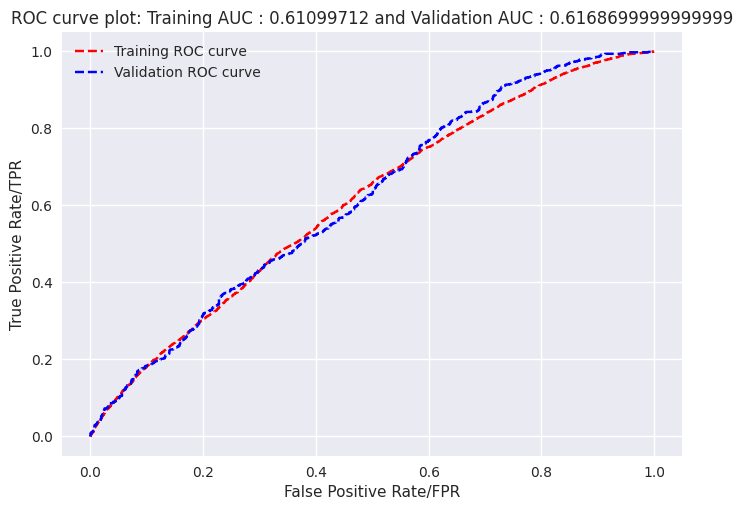

<Figure size 800x550 with 0 Axes>

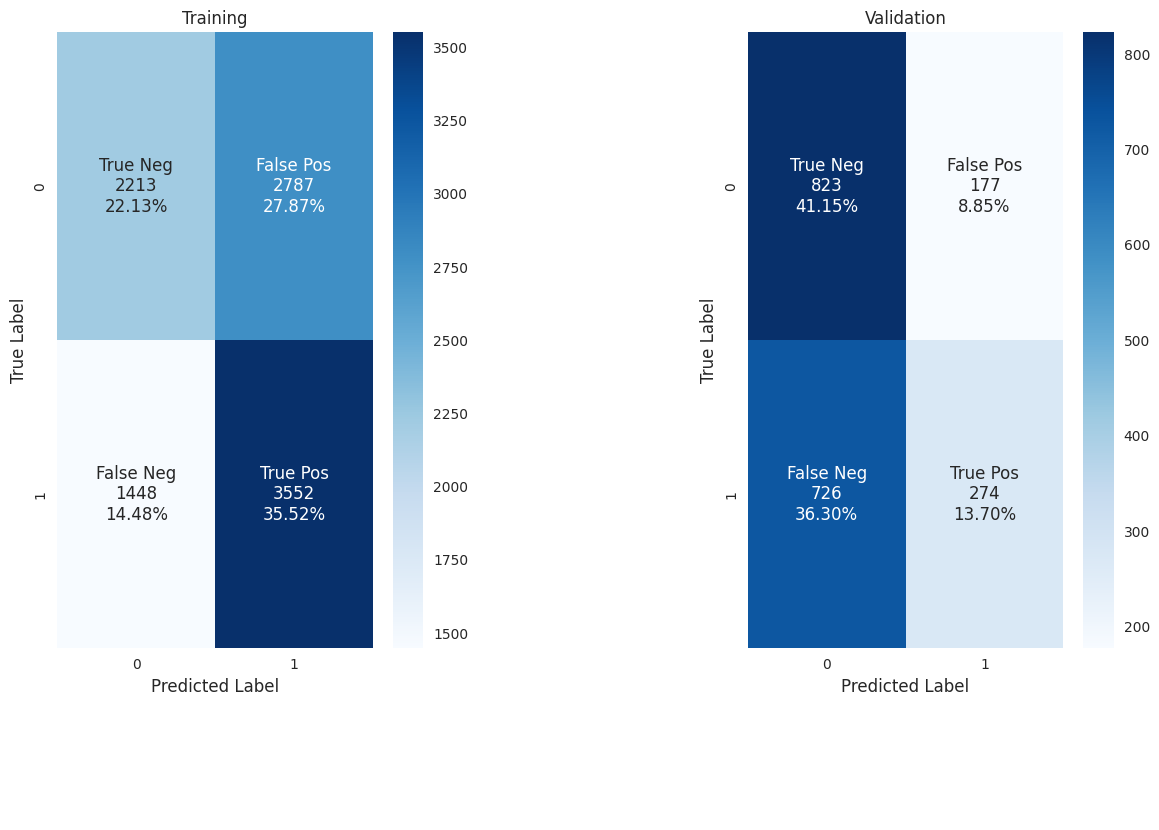

<Figure size 800x550 with 0 Axes>

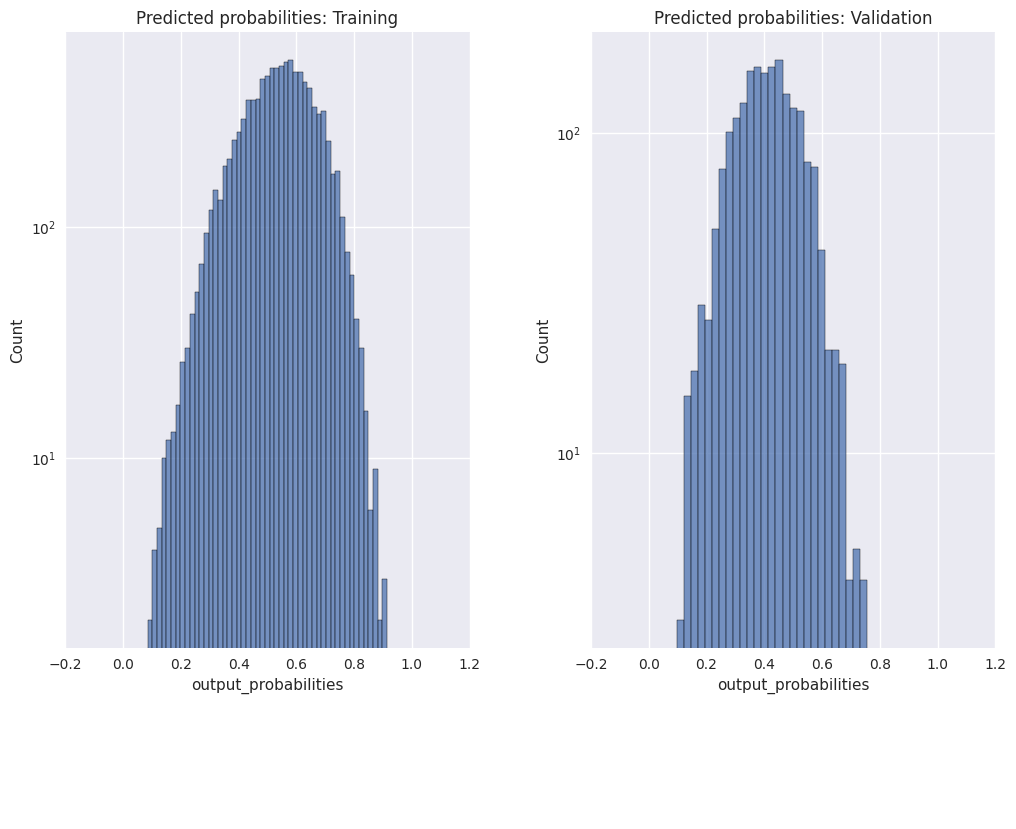

<Figure size 800x550 with 0 Axes>

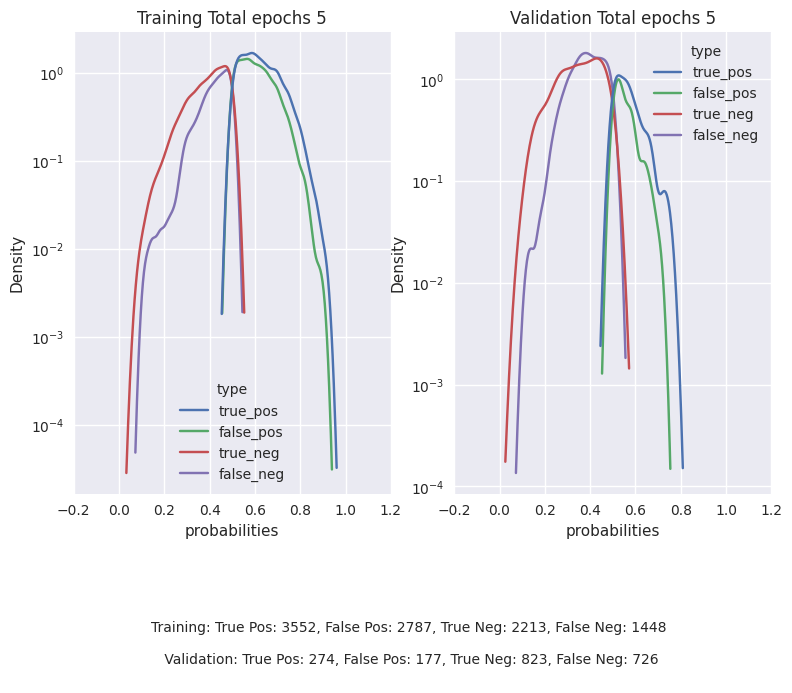

End time is 1699363332.536701


In [8]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")
    learningRate = arguments["learningRate"]
    numWorkers = arguments["numberOfWorkers"]
    numEpochs = arguments["numberEpochs"]
    batchSize = arguments["batchSize"]

    print(f"The model hyper parameters are Learning Rate: {learningRate}, numWorkers: {numWorkers}, numEpochs: {numEpochs}, batchSize: {batchSize}")
    
    #Iterate over each possible % samples and % features augmentation, train the model and store plots. 
    # sample_percents = [10, 30, 50, 70, 90]
    # feature_percents = [10, 30, 50, 70, 90]
    sample_percents = [10, 30]
    feature_percents = [10, 30]
    for sample_percent in sample_percents:
        for feature_percent in feature_percents:
            print(f"Starting the model for Sample percent : {sample_percent} and feature percent : {feature_percent}")
            model_name = f"sample_{sample_percent}_feature_{feature_percent}_percent"
            arguments["percentageFeaturesAsControls"] = feature_percent
            arguments["percentageSamplesAsControls"] = sample_percent
            
            #Create the directories for plots and checkpoints
            if(arguments["restoreFromCheckpoint"]):
                plots_directory_name = arguments["restoreCheckpointModelDirName"]
                plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
            else:
                now = datetime.now()
                filename_extension = now.strftime("%d_%m_%H_%M_%S")
                plots_directory_name = filename_extension + "_" + model_name
                plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
                os.mkdir(plots_directory_path)

            objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path)
    
    print(f"End time is {time.time()}")

        